## Notebook Imports

In [184]:
from os import walk
from os.path import join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image
import numpy as np

from sklearn.model_selection import train_test_split

%matplotlib inline

## Constants

In [282]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'

TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'

WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_FILE = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

## Reading Files

In [186]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [187]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

## Email body extraction

In [188]:
def email_body_generator(path):      
    
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            stream = open(filepath, encoding='latin-1')
            is_body = False
            lines = []
            for line in stream: 
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True
            stream.close()
            email_body = '\n'.join(lines)
            
            yield file_name, email_body
            

In [189]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [190]:
spam_emails = df_from_directory(SPAM_1_PATH, 1)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, 1))
spam_emails.head()

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [192]:
spam_emails.shape

(1898, 2)

In [193]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails.shape

(3901, 2)

In [195]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire dataframe is ', data.shape)
data.head()

Shape of entire dataframe is  (5799, 2)


,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


## Data Cleaning: Checking for Missing Values

In [196]:
data.drop(['cmds'], inplace=True)

data[4608:4611]

,MESSAGE,CATEGORY
00213.8b921d7940c5b2ac05892b648bd77231,I will be out of the office starting 02/08/20...,0
00214.4a5f7fc36eda589a5716dd090c67e90a,\n\n<rant>\n\nI swear to god you have to be so...,0
00215.676fa487d6122e4a57b37a5edffa4dc2,>> I swear to god you have to be so carefull w...,0


In [197]:
# check if any message bodies are null
data['MESSAGE'].isnull().values.any()

False

In [198]:
# check if there are empty emails (string length zero)
(data.MESSAGE.str.len() == 0).any()

False

In [199]:
(data.MESSAGE.str.len() == 0).sum()

0

### Locate empty emails

In [142]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

## Add Document IDs to Track Emails in Dataset

In [202]:
document_ids = range(0, data.shape[0])
data['DOC_ID'] = document_ids

In [146]:
data['FILE_NAME'] = data.index

In [203]:
data.set_index('DOC_ID', inplace=True)

In [204]:
data.head()

,MESSAGE,CATEGORY
DOC_ID,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
3,##############################################...,1
4,I thought you might like these:\n\n1) Slim Dow...,1


In [205]:
data.tail()

,MESSAGE,CATEGORY
DOC_ID,,
5791,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0
5792,"> >-- be careful when using this one.) Also, t...",0
5793,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0
5794,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0
5795,"Hi there,\n\n\n\nNow this is probably of no us...",0


### Save to File using Pandas

In [206]:
data.to_json(DATA_JSON_FILE)

## Number of Spam Messages Visualised (Pie Charts)

In [207]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [208]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

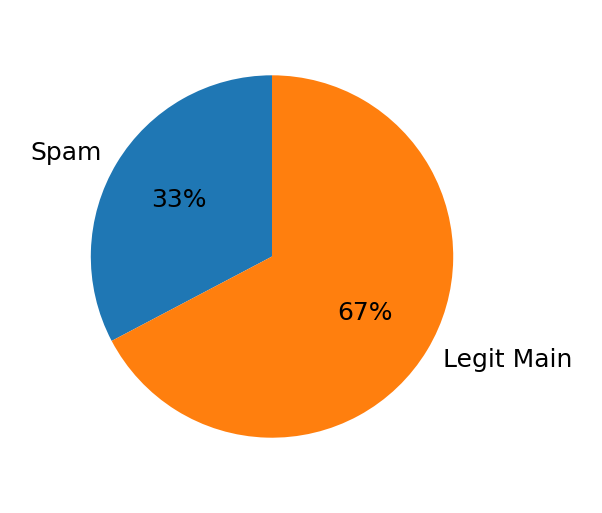

In [209]:
category_names = ['Spam', 'Legit Main']
sizes = [amount_of_spam, amount_of_ham]

plt.figure(figsize=(2, 2), dpi=300)
plt.pie(sizes, labels=category_names, textprops={'fontsize':6}, 
       startangle=90, autopct='%1.0f%%')
plt.show()

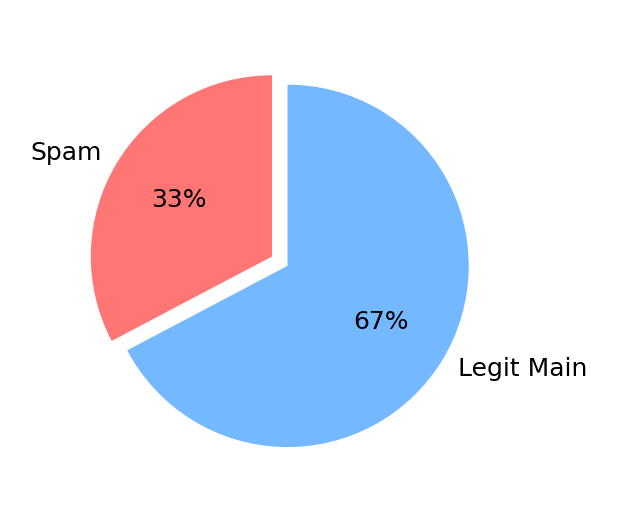

In [210]:
category_names = ['Spam', 'Legit Main']
sizes = [amount_of_spam, amount_of_ham]
custom_colors = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2, 2), dpi=300)
plt.pie(sizes, labels=category_names, textprops={'fontsize':6}, 
       startangle=90, autopct='%1.0f%%', 
       colors=custom_colors, explode=(0, .1))
plt.show()

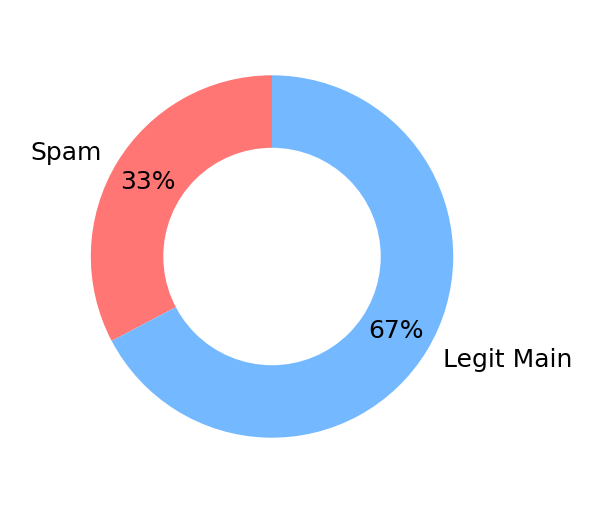

In [211]:
category_names = ['Spam', 'Legit Main']
sizes = [amount_of_spam, amount_of_ham]
custom_colors = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2, 2), dpi=300)
plt.pie(sizes, labels=category_names, textprops={'fontsize':6}, 
       startangle=90, autopct='%1.0f%%', 
       colors=custom_colors, pctdistance=.8)

# draw a circle
center_circle = plt.Circle((0, 0), radius=.6, fc='white')
plt.gca().add_artist(center_circle)

plt.show()

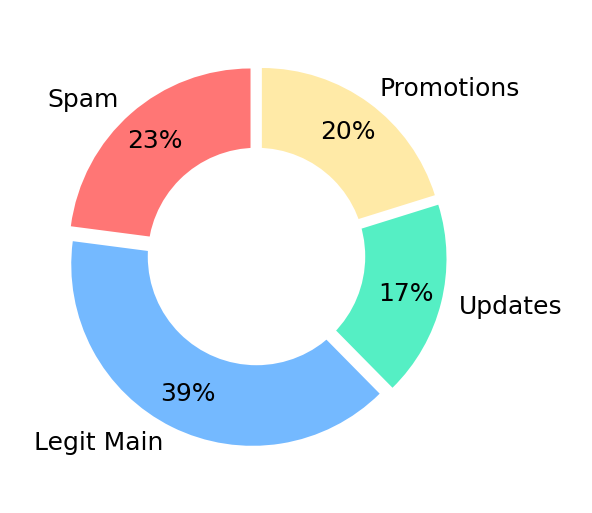

In [212]:
# Let's have fun and create a pie chart with more categories

category_names = ['Spam', 'Legit Main', 'Updates', 'Promotions']
sizes = [25, 43, 19, 22]
custom_colors = ['#ff7675', '#74b9ff', '#55efc4', '#ffeaa7']
offset = [.05, .05, .05, .05]

plt.figure(figsize=(2, 2), dpi=300)
plt.pie(sizes, labels=category_names, textprops={'fontsize':6}, 
       startangle=90, autopct='%1.0f%%', 
       colors=custom_colors, pctdistance=.8, 
       explode=offset)

# draw a circle
center_circle = plt.Circle((0, 0), radius=.6, fc='white')
plt.gca().add_artist(center_circle)

plt.show()

### Download the NLTK Resources (Tokenizer & Stopwords)

In [157]:
nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error Remote end closed
[nltk_data]     connection without response>


False

## Tokenising

In [158]:
msg = 'All work no play makes Jack a dull boy'
word_tokenize(msg.lower())

['all', 'work', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy']

## Removing Stop Words

In [213]:
stop_words = set(stopwords.words('english'))

In [214]:
if 'hello' in stop_words: 
    print('Found it')
else : print('Not Found')

Not Found


# Removing HTML tags from Emails & Stemming Wrods

In [215]:
def clean_message(message, stemmer=PorterStemmer(), 
                 stop_words=set(stopwords.words('english'))):
    
    # Converts to Lower Case and splits up the words
    words = word_tokenize(message.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [216]:
clean_message(email_body)[:5]

['dear', 'mr', 'still', 'good', 'tide']

In [257]:

def clean_msg_no_html(message, stemmer=PorterStemmer(), 
                 stop_words=set(stopwords.words('english'))):
    
    # Remove HTML tags
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()    
    
    # Converts to Lower Case and splits up the words
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
#             filtered_words.append(word) 
    
    return filtered_words

In [258]:
clean_msg_no_html(data.at[2, 'MESSAGE'])

['fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'child',
 'support',
 'deserv',
 'free',
 'legal',
 'advic',
 'http',
 'join',
 'web',
 'fastest',
 'grow',
 'singl',
 'commun',
 'http',
 'start',
 'privat',
 'photo',
 'album',
 'onlin',
 'http',
 'wonder',
 'day',
 'offer',
 'manag',
 'prizemama',
 'wish',
 'leav',
 'list',
 'pleas',
 'use',
 'link',
 'http',
 'zzzz']

## Apply Clearning and Tokenisation to all messages

In [227]:
%%time

# use apply() on all the messages in the dataframe
nested_list = data.MESSAGE.apply(clean_msg_no_html)

C:\Users\amir\Anaconda3\lib\site-packages\bs4\__init__.py:424: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning


Wall time: 1min 37s


In [228]:
nested_list.head()

DOC_ID
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, slim, guarante, lose, l...
Name: MESSAGE, dtype: object

In [229]:
nested_list.tail()

DOC_ID
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

### Using Logic to Slice DataFrames

In [230]:
doc_ids_spam = data[data['CATEGORY'] == 1].index
doc_ids_ham = data[data['CATEGORY'] == 0].index

In [231]:
nested_list_spam = nested_list.loc[doc_ids_spam]
nested_list_ham = nested_list.loc[doc_ids_ham]

In [232]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]

In [233]:
normal_words = pd.Series(flat_list_ham).value_counts()
normal_words.shape[0]

20815

In [234]:
spammy_words = pd.Series(flat_list_spam).value_counts()
spammy_words[:10]

http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64

## Creating a Word Cloud

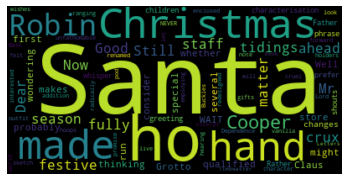

In [44]:
word_cloud = WordCloud().generate(email_body)

plt.axis('off')
plt.imshow(word_cloud, interpolation='bilinear')
plt.show()

In [45]:
### Let's have fun and download novels to create more interesting wordclouds
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\amir\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\amir\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

In [46]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

In [47]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [48]:
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)

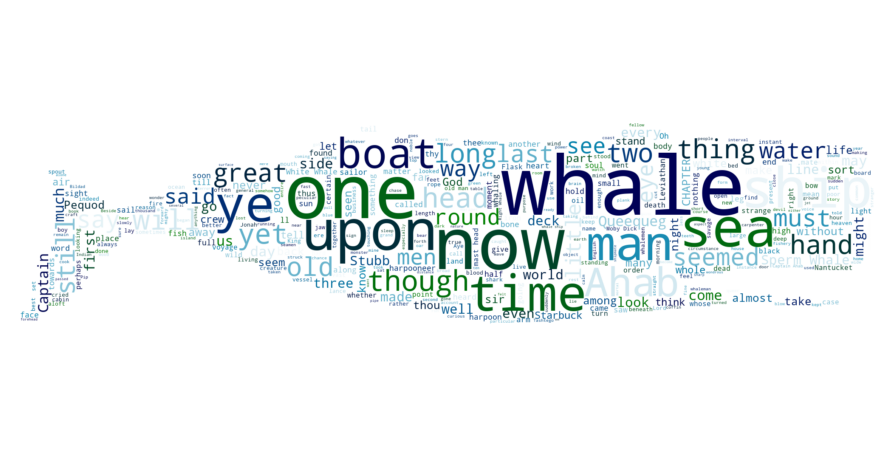

In [49]:
icon = Image.open(WHALE_FILE)
mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
mask.paste(icon, box=icon)
rgb_array = np.array(mask)

word_cloud = WordCloud(mask=rgb_array, 
                      background_color='white', 
                      max_words=400, 
                      colormap=cm.ocean).generate(novel_as_string)

plt.figure(figsize=(16, 8))
plt.axis('off')
plt.imshow(word_cloud, interpolation='bilinear')
plt.show()

In [50]:
# We have the materials, Lets plot the word cloud for Hamlet
hamlet_corpus = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
hamlet_list = [''.join(word) for word in hamlet_corpus]
hamlet = ' '.join(hamlet_list)

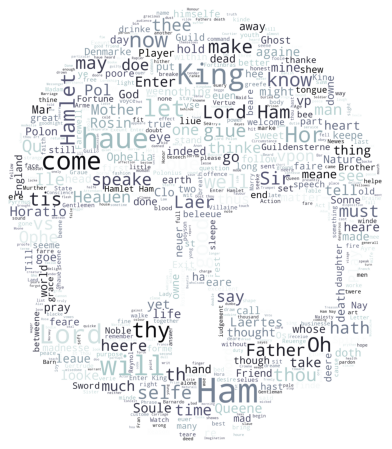

In [51]:
icon = Image.open(SKULL_FILE)
mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
mask.paste(icon, box=icon)

word_cloud = WordCloud(mask=np.array(mask), max_words=600, 
                      background_color='white', 
                      colormap=cm.bone).generate(hamlet)
plt.figure(figsize=(16, 8))
plt.axis('off')
plt.imshow(word_cloud)

# Word Cloud of Ham and Spam Messages

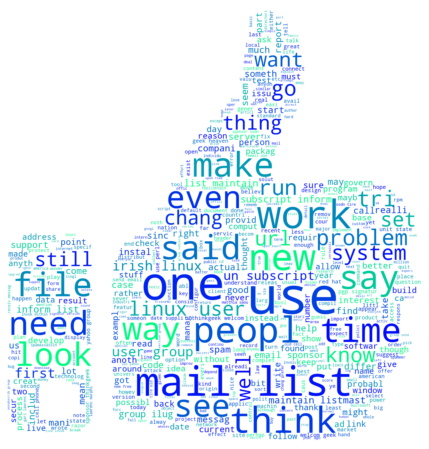

In [52]:
icon = Image.open(THUMBS_UP_FILE)
mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
mask.paste(icon, box=icon)
rgb_array = np.array(mask)

ham_str = ' '.join(flat_list_ham)

word_cloud = WordCloud(mask=rgb_array, 
                      background_color='white', 
                      max_words=500, 
                      colormap=cm.winter).generate(ham_str)

plt.figure(figsize=(16, 8))
plt.axis('off')
plt.imshow(word_cloud, interpolation='bilinear')
plt.show()

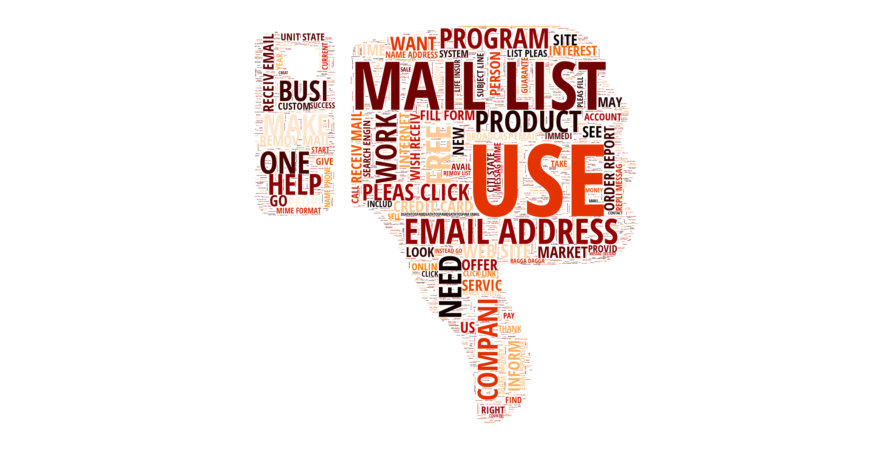

In [53]:
icon = Image.open(THUMBS_DOWN_FILE)
mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
mask.paste(icon, box=icon)
rgb_array = np.array(mask)

spam_str = ' '.join(flat_list_spam)

word_cloud = WordCloud(mask=rgb_array, 
                       font_path=CUSTOME_FONT_FILE,
                       max_font_size=300,
                       background_color='white', 
                       max_words=2000, 
                       colormap=cm.gist_heat).generate(spam_str.upper())

plt.figure(figsize=(16, 8))
plt.axis('off')
plt.imshow(word_cloud, interpolation='bilinear')
plt.show()

In [235]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

C:\Users\amir\Anaconda3\lib\site-packages\bs4\__init__.py:424: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning


In [236]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Nr of unique words', unique_words.shape[0])
unique_words.head()

Nr of unique words 27334


http     10660
use       5019
list      4851
email     4367
get       4200
dtype: int64

In [237]:
frequent_words = unique_words[0:VOCAB_SIZE]
print('Most common words: \n', frequent_words[:10])

Most common words: 
 http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
dtype: int64


### Creat Vocabulary DataFrame with a WORD_ID

In [238]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


## Save the Vocabulary as a CSV File

In [239]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

In [178]:
clean_email_lengths = [len(sublist) for sublist in stemmed_nested_list]
print('Nr words in the longest email:', max(clean_email_lengths))

Nr words in the longest email: 7671


In [179]:
print('Email position in the list (and the data dataframe)',
      np.argmax(clean_email_lengths))

Email position in the list (and the data dataframe) 5775


In [180]:
# stemmed_nested_list[np.argmax(clean_email_lengths)]

In [181]:
# data.at[np.argmax(clean_email_lengths), 'MESSAGE']

## Genrate features & a Sparse Matrix

### Creating a DataFrame with one Word per Column

In [240]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


In [241]:
word_columns_df.shape

(5796, 7671)

### Splitting the Data into a Training and Testing Dataset

In [242]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY,
                                                   test_size=0.3, random_state=42)

In [243]:
print('Nr of training samples', X_train.shape[0])
print('Fraction of training set', X_train.shape[0] / word_columns_df.shape[0])

Nr of training samples 4057
Fraction of training set 0.6999654934437544


In [244]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,ye,inde,agent,directori,verita,cd,unix,subdirectori,file,call,...,None,None,None,None,None,None,None,None,None,None
4727,problem,come,tri,instal,harddissssk,like,alreadi,mount,http,yahoo,...,None,None,None,None,None,None,None,None,None,None
5022,origin,messag,date,mon,aug,chad,norwood,sven,cc,subject,...,None,None,None,None,None,None,None,None,None,None
3504,inlin,folk,sever,major,internet,outag,morn,across,major,provid,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,date,bath,chronicl,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [245]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4675,interest,alway,wonder,thing,bad,exampl,goto,languag,support,goto,...,None,None,None,None,None,None,None,None,None,None
4220,url,http,date,final,gdc,europ,review,confernec,session,ect,...,None,None,None,None,None,None,None,None,None,None
2484,stephen,william,mailto,swilliam,weaken,food,transact,argument,note,neighborhood,...,None,None,None,None,None,None,None,None,None,None
2418,el,mon,sep,bitbitch,wrote,eugen,mani,homo,friend,lover,...,None,None,None,None,None,None,None,None,None,None
5110,music,school,joke,american,conductor,european,conductor,talk,european,conductor,...,None,None,None,None,None,None,None,None,None,None


In [246]:
y_train.head()

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

In [114]:
y_test.head()

DOC_ID
4675    0
4220    0
2484    0
2418    0
5110    0
Name: CATEGORY, dtype: int64

### Create a Sparse Matrix for the Training Data

In [247]:
word_index = pd.Index(vocab.VOCAB_WORD)

In [248]:
word_index.get_loc('thu')

394

In [249]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as dataframe.
    
    df: A dataframe with words in the columns with a document id as an index (X_train or X_test)
    indexed_words: index of words ordered by word id
    labels: category as a series (y_train or y_test)
    """
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id,
                       'OCCURENCE': 1, 'WORD_ID': word_id}
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)

In [250]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

Wall time: 19min 40s


In [251]:
sparse_train_df[:5]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,4844,1,265
1,0,4844,1,1239
2,0,4844,1,505
3,0,4844,1,308
4,0,4844,1,254


In [252]:
sparse_train_df.shape

(429238, 4)

In [253]:
sparse_train_df[-5:]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
429233,1,860,1,47
429234,1,860,1,1431
429235,1,860,1,26
429236,1,860,1,21
429237,1,860,1,126


### Combine Occurrences with Pandas groupby() method

In [267]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              2
       4       1              1
       7       1              3
       11      1              1

In [255]:
vocab.at[0, 'VOCAB_WORD']

'http'

In [268]:
train_grouped.reset_index(inplace=True)
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1


In [269]:
train_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
258363,5795,2036,0,2
258364,5795,2275,0,1
258365,5795,2350,0,1
258366,5795,2381,0,1
258367,5795,2497,0,1


In [273]:
vocab.at[1923, 'VOCAB_WORD']

'honest'

In [276]:
train_grouped.shape

(258368, 4)

### Save Training Data as .txt File 

In [280]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [287]:
%%time

sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

Wall time: 23min 40s


In [288]:
sparse_test_df.shape

(203385, 4)

In [289]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()

In [290]:
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,2,1,1
1,8,3,1,4
2,8,4,1,2
3,8,5,1,1
4,8,6,1,2


In [291]:
test_grouped.shape

(117789, 4)

In [293]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

### Pre-Processing Subtleties and Checking our Undrestanding

In [294]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

In [296]:
len(test_doc_ids)

1724

In [297]:
len(X_test)

1739

In [300]:
set(X_test.index) - test_doc_ids

{134, 179, 240, 274, 298, 339, 439, 471, 670, 734, 765, 945, 1544, 1670, 1700}